In [1]:
# Install necessary packages

!pip install scikit-learn wget "ibm-watson-machine-learning>=1.0.310"


  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=6d8abe853402f3f3fc61b33edf09adcee8750d368afb78fd832bccb6dc20e0d8
  Stored in directory: /tmp/wsuser/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget


In [32]:
#  Set your IBM credentials

from getpass import getpass

url = "https://us-south.ml.cloud.ibm.com"
apikey = getpass("🔐 Enter your IBM API Key (hidden): ")

credentials = {
    "url": url,
    "apikey": apikey
}


🔐 Enter your IBM API Key (hidden):  ········


In [3]:
# Set your Watsonx project ID

import os
project_id = os.environ.get("PROJECT_ID", input("Please enter your project_id: "))


Please enter your project_id:  5573af45-ff1e-4a37-8a2c-d25479afc918


In [33]:
# Set up COS access

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=apikey,
    ibm_auth_endpoint='https://iam.cloud.ibm.com/oidc/token',
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.us-south.cloud-object-storage.appdomain.cloud'
)

bucket = "handson-7q51r6swm8ybwa0"
object_key = "college_feedback.csv"

body = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']
if not hasattr(body, "_iter_"):
    body._iter_ = types.MethodType(lambda self: self, body)
data = pd.read_csv(body)
data.head()


,Feedback,Category
0,Professors are well-qualified and always ready...,Academics
1,The curriculum is regularly updated and relevant.,Academics
2,Assignments are given on time and checked prom...,Academics
3,Labs are well-equipped and maintained.,Academics
4,Exams are conducted fairly.,Academics


In [36]:
# Visualization of data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


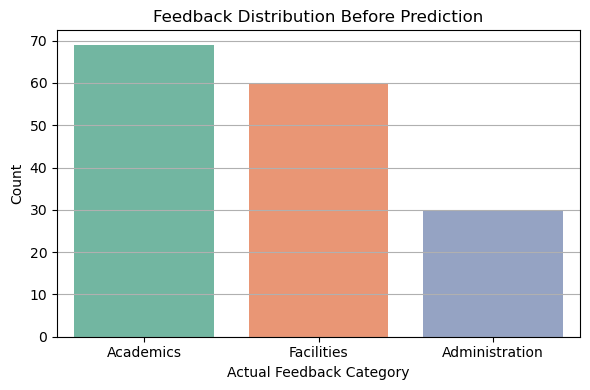

In [37]:
# Plot Feedback Category Distribution Before Prediction

# BEFORE PREDICTION - using original dataset
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Category', palette='Set2')
plt.title("Feedback Distribution Before Prediction")
plt.xlabel("Actual Feedback Category")
plt.ylabel("Count")
plt.grid(axis='y')
plt.tight_layout()
plt.show()



In [39]:
# Preprocess and Split the Dataset

from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test = train_test_split(
    data['Feedback'], data['Category'], test_size=0.3, random_state=42, stratify=data['Category']
)

data_train = pd.DataFrame({'Feedback': data_train, 'Category': y_train})
data_test = pd.DataFrame({'Feedback': data_test, 'Category': y_test})


In [40]:
# Created Few-Shot Prompt Examples

few_shot_example = []

# Select 2 examples per category
for feedback, category in data_train.groupby('Category').apply(lambda x: x.sample(2)).values:
    few_shot_example.append(f"\tfeedback: {feedback}\n\tcategory: {category}")

few_shot_examples = '\n'.join(few_shot_example)

instruction = """Classify the student feedback into one of the following categories:
- Academics
- Facilities
- Administration

Use the following examples:\n""" + few_shot_examples


In [41]:
# Loaded the Foundation Model

from ibm_watson_machine_learning.foundation_models.utils.enums import ModelTypes
from ibm_watson_machine_learning.foundation_models import Model
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams

parameters = {
    GenParams.DECODING_METHOD: "greedy",
    GenParams.RANDOM_SEED: 42,
    GenParams.REPETITION_PENALTY: 1,
    GenParams.MIN_NEW_TOKENS: 1,
    GenParams.MAX_NEW_TOKENS: 10
}

model_id = ModelTypes.FLAN_T5_XXL  

model = Model(
    model_id=model_id,
    params=parameters,
    credentials=credentials,
    project_id=project_id
)


/opt/conda/envs/Python-RT24.1/lib/python3.11/site-packages/ibm_watson_machine_learning/foundation_models/utils/utils.py:273: LifecycleWarning: Model 'google/flan-t5-xxl' is in deprecated state from 2025-05-28 until 2025-07-30. IDs of alternative models: None. Further details: https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/fm-model-lifecycle.html?context=wx&audience=wdp
  warnings.warn(default_warning_template.format(


In [51]:
#  Predictions are Run 

# Prepare all test inputs
few_shot_inputs = [{"input": f} for f in data_test['Feedback'].values]

results = []

# Loop through all inputs and predict
for inp in few_shot_inputs:
    prompt = instruction + f"\n\nfeedback: {inp['input']}\ncategory:"
    try:
        response = model.generate(prompt)
        prediction = response["results"][0]["generated_text"].strip()
    except Exception as e:
        prediction = "error"
        print(f"Error processing: {inp['input'][:50]}... \n{e}")
    
    results.append(prediction)



In [52]:
df_eval.to_csv("classified_feedback_results.csv", index=False)


In [50]:
print(df_eval.shape)  # Should print (N, 3) where N = total test rows


(48, 3)


In [53]:
import pandas as pd

# Full ground truth and predictions (no slicing!)
y_true = y_test.values
y_pred = results

# Create evaluation DataFrame
df_eval = pd.DataFrame({
    'Feedback': data_test['Feedback'].values,
    'Actual Category': y_true,
    'Predicted Category': y_pred
})

# Preview top rows
print(df_eval.head(10))





                                            Feedback Actual Category  \
0                      Wi-Fi connectivity is strong.      Facilities   
1                    Too much paperwork is involved.  Administration   
2                        Common rooms are available.      Facilities   
3  The curriculum is regularly updated and relevant.       Academics   
4               Faculty members encourage questions.       Academics   
5                   Computers are in good condition.      Facilities   
6                       Grievance redressal is slow.  Administration   
7                Workshops are frequently conducted.       Academics   
8             Course content matches industry needs.       Academics   
9                      Study materials are provided.       Academics   

  Predicted Category  
0         Facilities  
1     Administration  
2         Facilities  
3          Academics  
4          Academics  
5         Facilities  
6     Administration  
7          Academics  


In [54]:
cos_client.upload_file(
    Filename='classified_feedback_results.csv',
    Bucket=bucket,
    Key='classified_feedback_results.csv'
)


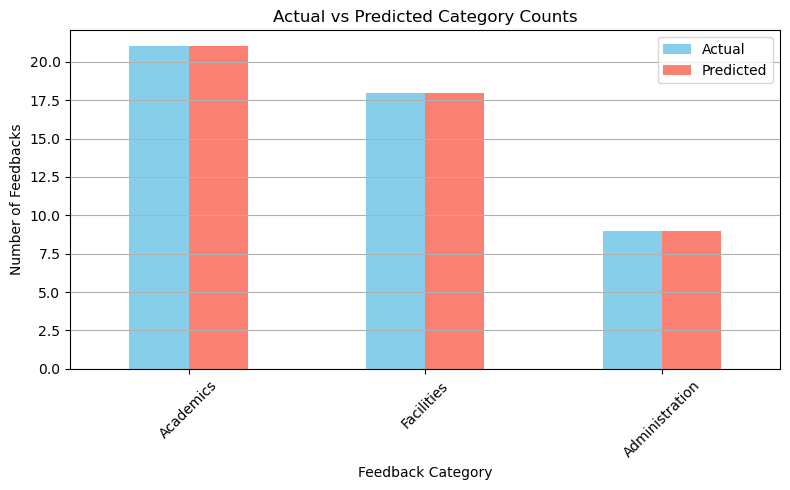

In [55]:
# Actual vs Predicted Category Counts

actual_counts = df_eval['Actual Category'].value_counts()
predicted_counts = df_eval['Predicted Category'].value_counts()

comparison_df = pd.DataFrame({
    'Actual': actual_counts,
    'Predicted': predicted_counts
}).fillna(0)

comparison_df.plot(kind='bar', figsize=(8, 5), color=['skyblue', 'salmon'])
plt.title("Actual vs Predicted Category Counts")
plt.ylabel("Number of Feedbacks")
plt.xlabel("Feedback Category")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


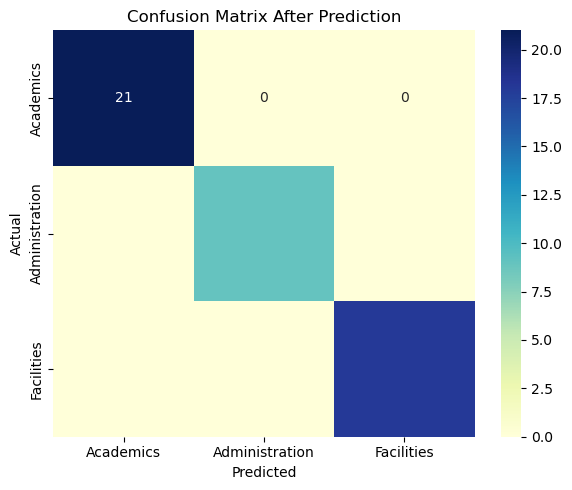

In [56]:
# Confusion Matrix (Accuracy Visual)

from sklearn.metrics import confusion_matrix

labels = sorted(df_eval['Actual Category'].unique())
cm = confusion_matrix(df_eval['Actual Category'], df_eval['Predicted Category'], labels=labels)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix After Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



In [57]:
# Classification Report

from sklearn.metrics import classification_report

print(classification_report(df_eval['Actual Category'], df_eval['Predicted Category']))


                precision    recall  f1-score   support

     Academics       1.00      1.00      1.00        21
Administration       1.00      1.00      1.00         9
    Facilities       1.00      1.00      1.00        18

      accuracy                           1.00        48
     macro avg       1.00      1.00      1.00        48
  weighted avg       1.00      1.00      1.00        48

